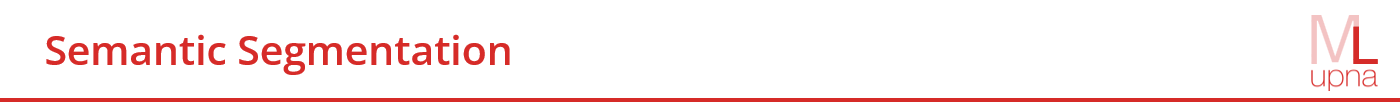

In [12]:
# Buid dataset from folder structure

from glob import glob
import pandas as pd

images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


In [ ]:
import pytorch_lightning as pl
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.models import ResNet50_Weights
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from skimage.io import imread  # or your preferred image loader
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import f1_score, iou_score
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.v2 as T
import torchvision



In [14]:
DATA_DIR = 'clothes'
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value 
class_names[0] = 'null'
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('\nClass Names: ', class_names)
print('\nClass RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:

Class Names:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

Class RGB values:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [50, 99, 141], [48, 103, 141], [46, 107, 142], [

In [23]:
def rgb_to_class(mask, class_rgb_values):
    """
    Convert an RGB segmentation mask to a class index mask.
    mask: (H, W, 3)
    returns: (H, W) with class IDs.
    """
    h, w, _ = mask.shape
    mask_flat = mask.reshape(-1, 3)

    class_id_mask = np.zeros((h*w,), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        matches = np.all(mask_flat == rgb, axis=-1)
        class_id_mask[matches] = class_id

    return class_id_mask.reshape(h, w)


def class_to_rgb(mask, class_rgb_values):
    """
    Convert a class-index mask (H,W) back to an RGB mask (H,W,3)
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        rgb_mask[mask == class_id] = rgb

    return rgb_mask

class CCPDataset(torch.utils.data.Dataset):

    def __init__(self, df, patch_size=224, transforms=None, mode='train'):
        super(CCPDataset, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, idx):

        # Take the idx-th row from the DataFrame
        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Convert into multi class mask
        y = rgb_to_class(y, class_rgb_values)

        if self.mode == 'eval': # If we are evaluating (valid or test set) perform a subset based on the given coordinates
            x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                    
        # Convert to PIL image. Converting to PIL before calling the v2 transforms makes the behavior consistent across torchvision versions.
        x = to_pil_image(x.astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')
        
        # Apply transforms
        if self.transforms:
            x, y = self.transforms[0](x, y) # First, transforms for both image and mask synchronized
            x = self.transforms[1](x) # Second, tranforms for only images

        # PIL to Tensor
        y = (torchvision.transforms.functional.to_tensor(y) *255).type(torch.long).squeeze(0)
            
        return x, y

    def __show_item__(self, x, y):
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(x.permute(1, 2, 0))
        ax[0].set_title('Image')
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(y[0])
        ax[1].set_title('Mask')
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(x.permute(1, 2, 0))
        ax[2].imshow(y[0], alpha=.5, vmin=0, vmax=1)
        ax[2].set_title('Overlay')
        ax[2].set_xticks([])
        ax[2].set_yticks([])

        plt.show()
        

    def __len__(self): 
        return self.df.shape[0]

class DataModule(pl.LightningDataModule):
    def __init__(self, df, bs, ps):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps

    def patch_origins(self, h, w, ps, overlap=.5):
    
        if ps > h or ps > w:
            raise ValueError("Patch size ps must be <= image dimensions h and w")
    
        stride = int(ps * overlap)
        if stride <= 0:
            raise ValueError("Patch size too small")
    
        hs = list(range(0, h - ps + 1, stride))
        ws = list(range(0, w - ps + 1, stride))
    
        # make sure the last patch touches the image border
        if hs[-1] != h - ps:
            hs.append(h - ps)
        if ws[-1] != w - ps:
            ws.append(w - ps)
    
        origins = [(h, w) for h in hs for w in ws]
        return np.array(origins, dtype=int)

    def setup(self, stage): # Data preparation and transforms

        train_transforms = (
            T.Compose([
                T.RandomCrop((224, 224)),
                T.Resize(size=(256, 256)),                
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )

        eval_transforms = (
            T.Compose([
                T.Resize(size=(256, 256)),    
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        
        self.train_ds = CCPDataset(df=self.df.query('set == "train"'), patch_size=self.ps, transforms=train_transforms)

        valid_df = self.df.query('set == "valid"')
        valid_df['coords'] = valid_df.image_path.apply(lambda x : self.patch_origins(*imread(x).shape[:-1], ps=self.ps, overlap=1).tolist())
        valid_df = valid_df.explode('coords')

        test_df = self.df.query('set == "test"')
        test_df['coords'] = test_df.image_path.apply(lambda x : self.patch_origins(*imread(x).shape[:-1], ps=self.ps, overlap=1).tolist())
        test_df = test_df.explode('coords')
        
        self.valid_ds = CCPDataset(df=valid_df, patch_size=self.ps, transforms=eval_transforms, mode='eval')
        self.test_ds = CCPDataset(df=test_df, patch_size=self.ps, transforms=eval_transforms, mode='eval')

    def train_dataloader(self): return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=8)

    def val_dataloader(self): return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False, num_workers=8)

    def test_dataloader(self): return torch.utils.data.DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=8)

/tmp/ipykernel_286917/3849894971.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['coords'] = valid_df.image_path.apply(lambda x : self.patch_origins(*imread(x).shape[:-1], ps=self.ps, overlap=1).tolist())
/tmp/ipykernel_286917/3849894971.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['coords'] = test_df.image_path.apply(lambda x : self.patch_origins(*imread(x).shape[:-1], ps=self.ps, overlap=1).tolist())
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/d

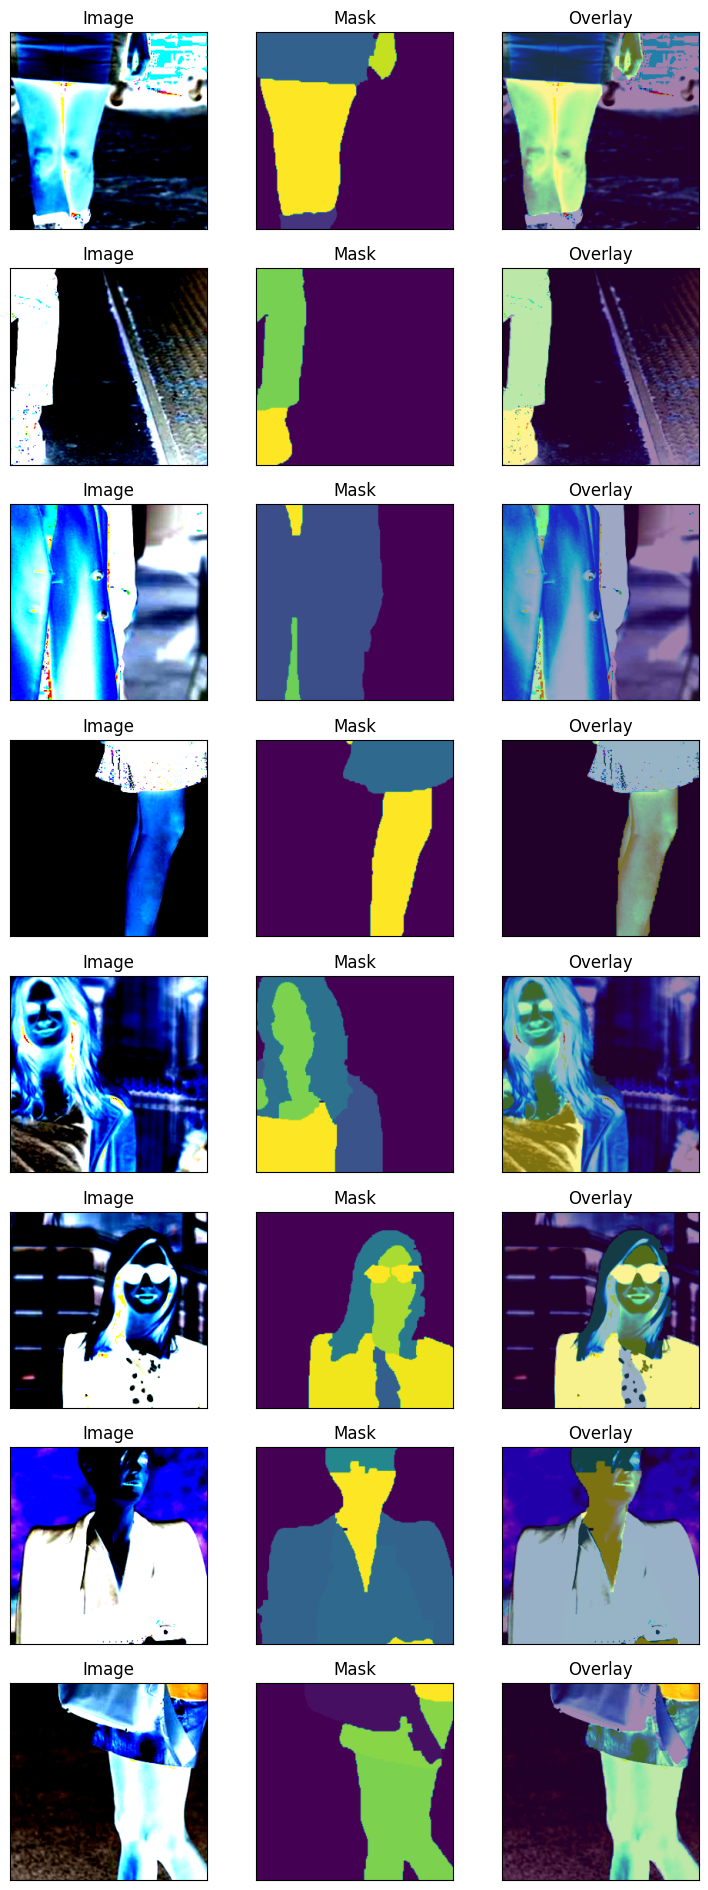

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.4308503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.4308503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].


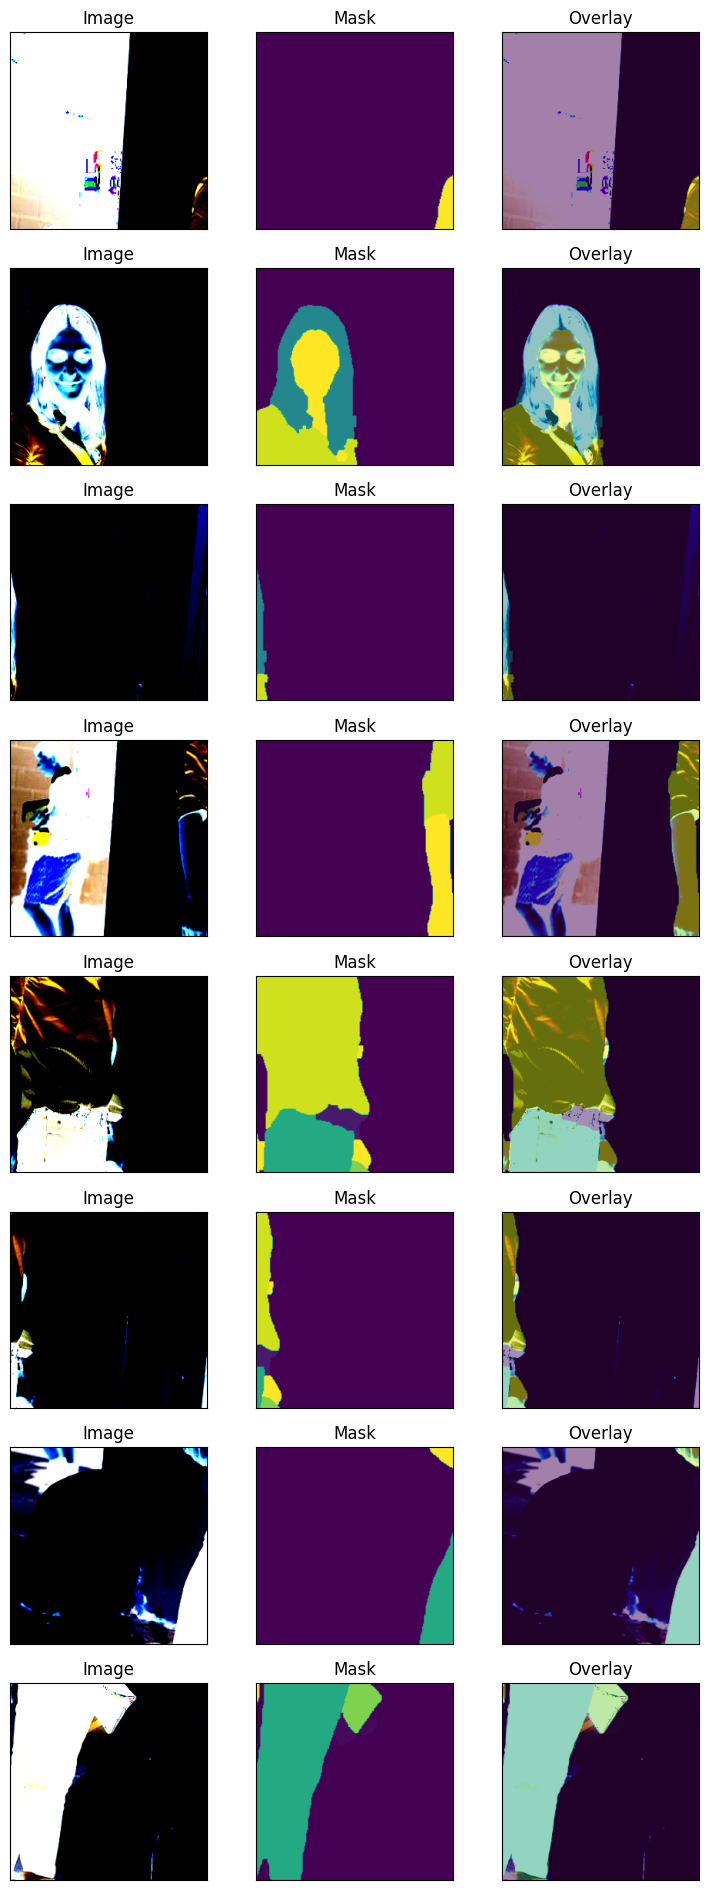

In [18]:
data_module = DataModule(df, bs=8, ps=224)
data_module.setup('test')

train_dataloader = data_module.train_dataloader()
batch = next(iter(train_dataloader))

x, y = batch
bs = x.shape[0]
f, ax = plt.subplots(bs, 3, figsize=(9, bs*3))
for i in range(bs):
    ax[i][0].imshow(x[i].permute(1, 2, 0))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_title('Image')

    ax[i][1].imshow(y[i][0])
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_title('Mask')

    ax[i][2].imshow(x[i].permute(1, 2, 0))
    ax[i][2].imshow(y[i][0], alpha=.5)
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][2].set_title('Overlay')

plt.show()

valid_dataloader = data_module.val_dataloader()
batch = next(iter(valid_dataloader))

x, y = batch
bs = x.shape[0]
f, ax = plt.subplots(bs, 3, figsize=(9, bs*3))
for i in range(bs):
    ax[i][0].imshow(x[i].permute(1, 2, 0))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_title('Image')

    ax[i][1].imshow(y[i][0])
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_title('Mask')

    ax[i][2].imshow(x[i].permute(1, 2, 0))
    ax[i][2].imshow(y[i][0], alpha=.5)
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][2].set_title('Overlay')

plt.show()

In [19]:
import segmentation_models_pytorch as smp
from lightning.pytorch.loggers import CSVLogger
from torch.nn import functional as F
from collections import defaultdict

# UNet

In [20]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [24]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # DeepLabV3+ model
        self.model = smp.Unet(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)
        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [25]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/ccp_unet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/tmp/ipykernel_286917/2951313906.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['coords'] = valid_df.image_path.apply(lambda x : self.patch_origins(*imread(x).shape[:-1], ps=self.ps, overlap=1).tolist())
/tmp/ipykernel_286917/2951313906.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['coords'] = test_df.image_path.apply(lambda x : self.patch_origins

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.029019              NaN          0.625975   
1      1    21          0.052797              NaN          0.587676   
2      2    32          0.060042              NaN          0.594017   
3      3    43          0.070368              NaN          0.580044   
4      4    49          0.080430         0.067863          0.558392   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.019202              NaN  0.008291  0.544816   
1              NaN          0.035619              NaN  0.011786  0.537260   
2              NaN          0.041986              NaN  0.010022  0.543024   
3              NaN          0.051340              NaN  0.084291  0.508189   
4         0.597932          0.059121         0.049446  0.059028  0.509405   

   val_miou  
0  0.004284  
1  0.006269  
2  0.005301  
3  0.062229  
4  0.037727  


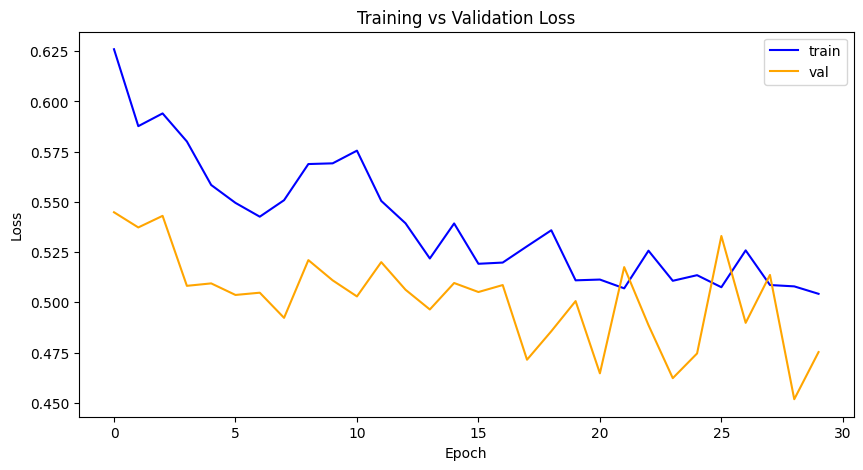

In [ ]:
metric_df = pd.read_csv(f'experiments/ccp_unet/version_0/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

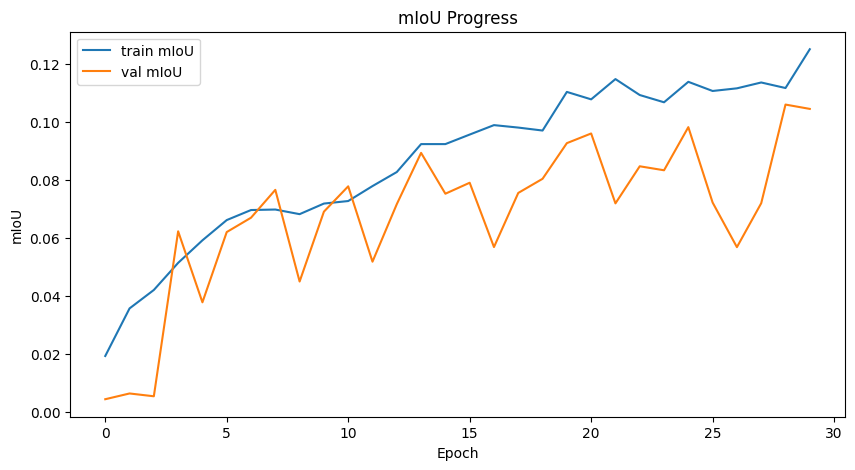

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


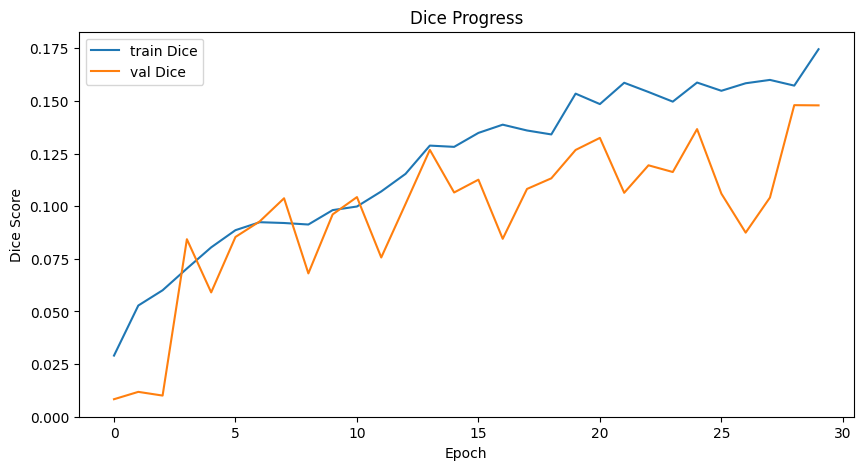

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# DeepLab v3 plus

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # DeepLabV3+ model
        self.model = smp.DeepLabV3Plus(
            encoder_name='resnet101',     # better accuracy
            encoder_weights='imagenet',
            in_channels=3,
            classes=59,
            encoder_output_stride=16      # better detail
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss



In [ ]:
pl.seed_everything(seed=42, workers=True)

lightning_module = LightningModule()

csv_logger = CSVLogger(
    save_dir=os.getcwd(),
    name="experiments/ccp_deeplabv3plus"
)

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    filename='best_valid_loss',
    verbose=True,
    save_last=False
)

trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    callbacks=[model_checkpoint_callback]
)

data_module = DataModule(df, bs=64, ps=224)

trainer.fit(lightning_module, data_module)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | DeepLabV3Plus          | 45.7 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.738   Total estimated model params size (MB)
348       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.53784 (best 0.53784), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' reached 0.53459 (best 0.53459), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' reached 0.52372 (best 0.52372), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' reached 0.49936 (best 0.49936), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' reached 0.49604 (best 0.49604), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' reached 0.49298 (best 0.49298), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' reached 0.47407 (best 0.47407), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' reached 0.46510 (best 0.46510), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' reached 0.43914 (best 0.43914), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.049740              NaN          0.608195   
1      1    21          0.075438              NaN          0.581845   
2      2    32          0.099349              NaN          0.557183   
3      3    43          0.102445              NaN          0.553389   
4      4    49          0.114830         0.134239          0.558502   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.031856              NaN  0.033920  0.537841   
1              NaN          0.051371              NaN  0.046389  0.539083   
2              NaN          0.068894              NaN  0.029948  0.582675   
3              NaN          0.071468              NaN  0.086733  0.534591   
4         0.471378          0.080343         0.094489  0.061421  0.523718   

   val_miou  
0  0.020721  
1  0.031071  
2  0.016808  
3  0.057925  
4  0.040234  


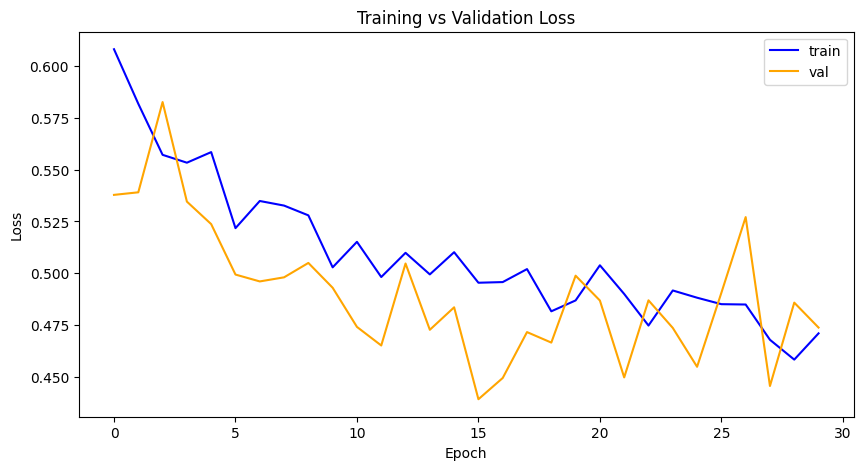

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

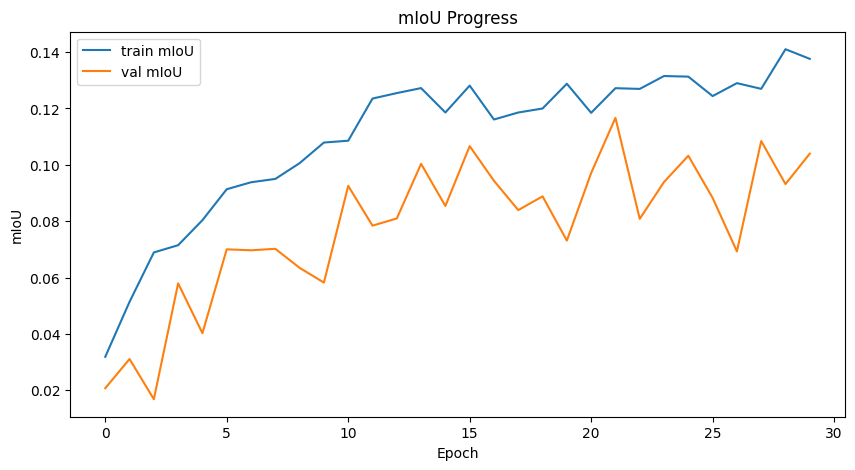

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


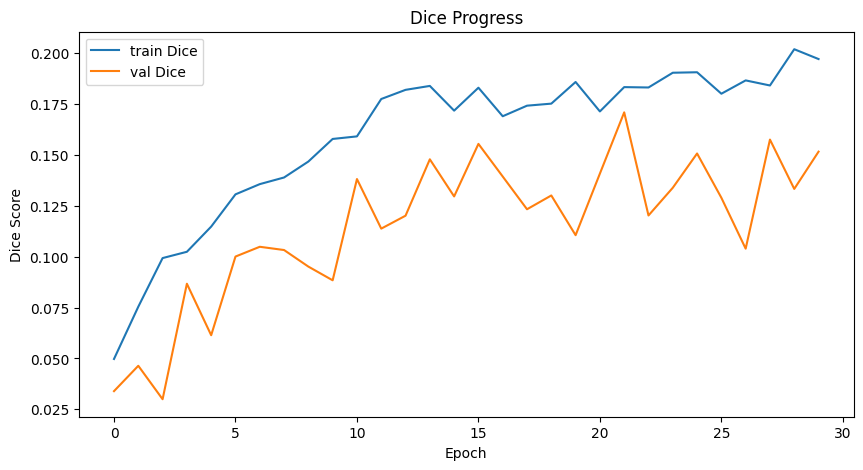

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# FPN

In [ ]:
model = smp.FPN(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # FPN model
        self.model = smp.FPN(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [ ]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/fpn")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | FPN                    | 26.1 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.494   Total estimated model params size (MB)
214       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.55044 (best 0.55044), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 0.50966 (best 0.50966), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' reached 0.48245 (best 0.48245), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' reached 0.47370 (best 0.47370), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' reached 0.46751 (best 0.46751), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' reached 0.46206 (best 0.46206), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' reached 0.45505 (best 0.45505), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.019924              NaN          0.612040   
1      1    21          0.056888              NaN          0.589240   
2      2    32          0.069597              NaN          0.572466   
3      3    43          0.088133              NaN          0.564238   
4      4    49          0.096067         0.106598          0.555018   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.011375              NaN  0.010917  0.550441   
1              NaN          0.036976              NaN  0.049576  0.556947   
2              NaN          0.046388              NaN  0.073400  0.509657   
3              NaN          0.059030              NaN  0.068067  0.528106   
4         0.531377          0.064291         0.070893  0.077194  0.518268   

   val_miou  
0  0.005822  
1  0.031820  
2  0.048456  
3  0.043079  
4  0.052212  


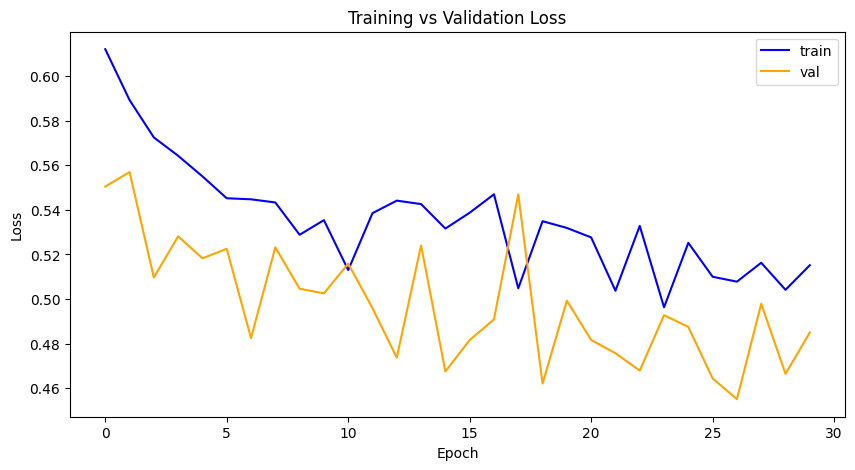

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

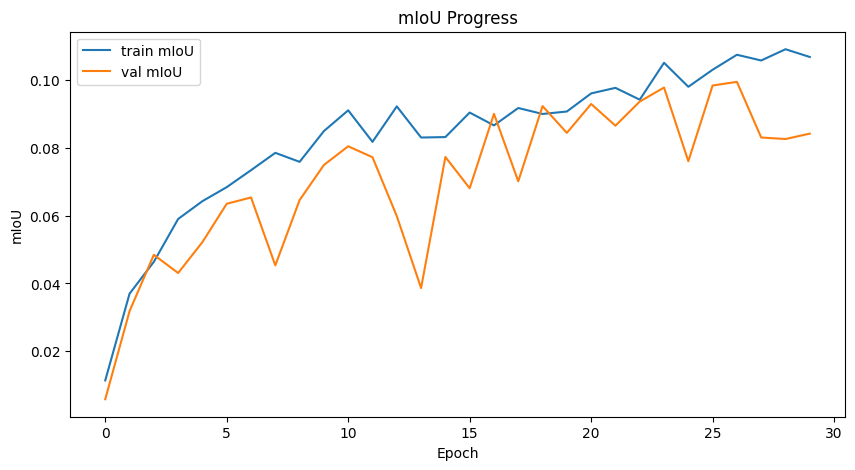

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


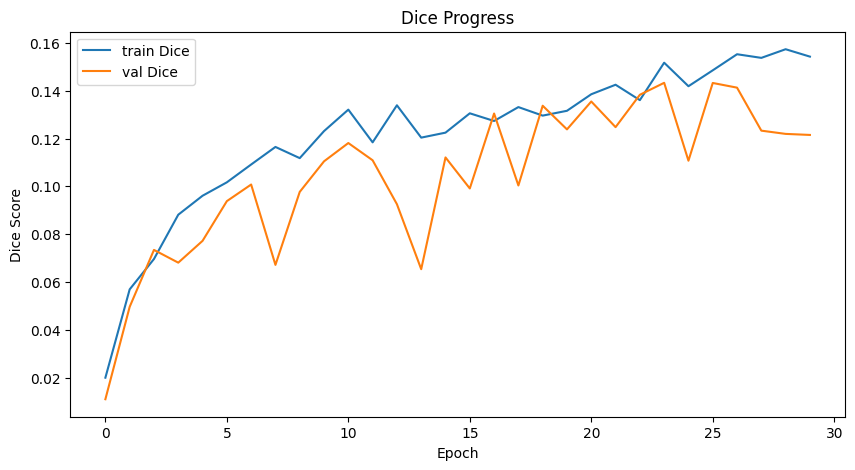

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# PSPnet

In [ ]:
model = smp.PSPNet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # FPN model
        self.model = smp.UnetPlusPlus(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [ ]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/pspnet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | UnetPlusPlus           | 49.0 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.977   Total estimated model params size (MB)
306       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.55996 (best 0.55996), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' reached 0.55470 (best 0.55470), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 0.53195 (best 0.53195), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' reached 0.51452 (best 0.51452), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1
Traceback (most recent call last):
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py", line 268, in _feed
    send_bytes(obj)
    ~~~~~~~~~~^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
    ~~~~~~~~~~^^^^^^^^^^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' reached 0.50188 (best 0.50188), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' reached 0.47468 (best 0.47468), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' reached 0.47074 (best 0.47074), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' reached 0.46790 (best 0.46790), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' reached 0.45107 (best 0.45107), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.020199              NaN          0.604587   
1      1    21          0.040878              NaN          0.596994   
2      2    32          0.062345              NaN          0.574095   
3      3    43          0.064020              NaN          0.583590   
4      4    49          0.069497         0.061885          0.577306   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.011960              NaN  0.014972  0.559957   
1              NaN          0.026725              NaN  0.029616  0.554696   
2              NaN          0.043936              NaN  0.031891  0.531946   
3              NaN          0.045534              NaN  0.053669  0.514521   
4         0.556771          0.049647         0.042759  0.068629  0.501879   

   val_miou  
0  0.008582  
1  0.018109  
2  0.019087  
3  0.036799  
4  0.049440  


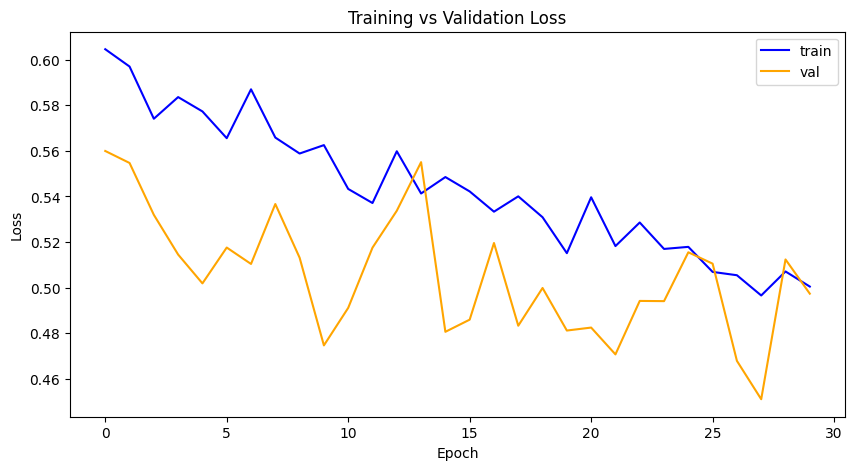

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

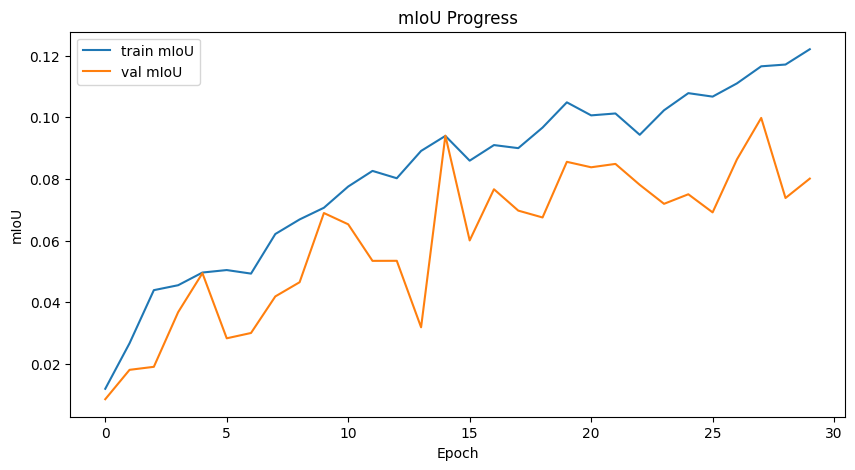

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


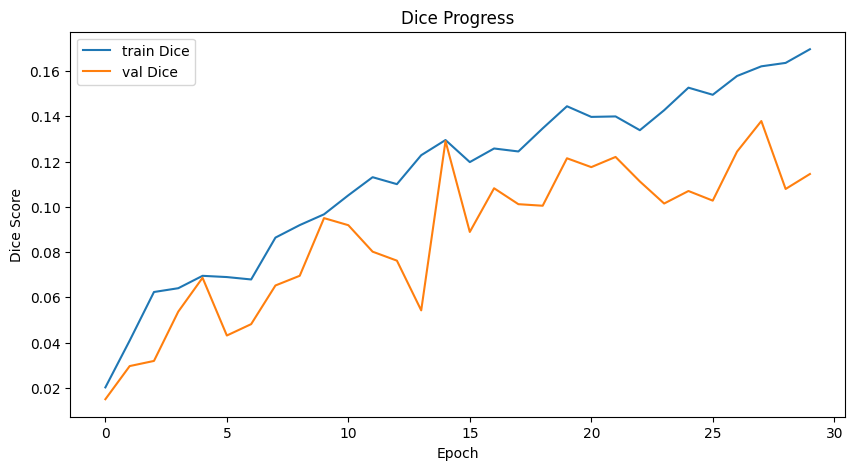

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()
